In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [2]:
dimension_33d = pd.read_csv('../input_data/RelDim_labels/dimensions_33d.csv',index_col=0)
dimension_33d = dimension_33d.iloc[:,0].to_list() 

relationships = pd.read_csv('../input_data/RelDim_labels/159relationships_fix_label.csv',index_col=0)
relationships = relationships.iloc[:,0].to_list()

key = pd.read_csv('../input_data/RelDim_labels/credamo_question_key.csv')

Helper function

In [3]:
def clean_data(vnum,region,Qstart,Qend):
    """
    separate different parts from all items
    parameter:
        vnum: the version of survey
        region: data collecting in region / country
        Qstart,Qend: control the item index of main questions

    output:
        'main': main part of questions
        'dim_com': comprehension of dimensions
        'rel_size': check items
        'familiarity': familiarity of relationships rated
    """
    result_df = {}
    #import data
    file_path = '../input_data/Nations/'+region+'/'+region+'_'+str(vnum)+'.csv'
    raw_data = pd.read_csv(file_path,index_col=None, header=1,encoding='UTF-8')
    #drop 'suggestion'
    raw_reorg = raw_data.drop(['Q42'], axis=1)
    raw_reorg['subject'] = list(raw_reorg.index)
    raw_reorg = raw_reorg.reset_index(drop=True)
    
    response = raw_reorg
    response['subject'] = list(raw_reorg.index)
    response = response.loc[:,response.columns.str.startswith('Q')]
    
    
    #Questionnaires
    #main question:V1,Q4-14;V2,Q15-Q25;V3,Q26-Q33,Q35-Q36,Q38
    count = Qstart
    filtered_main = []
    while count <= Qend:
        [filtered_main.append(col) for col in raw_reorg if col.startswith('Q'+str(count)+'_2')]
        if count == 33 or count == 36:
            count = count + 2
        else:
            count += 1
    response_main = response[filtered_main]

    #check_rel_size:Q39,Q40
    filtered_rel_size = [col for col in raw_reorg if (col.startswith('Q39'))|(col.startswith('Q40'))]
    response_rel_size = response[filtered_rel_size]
    
    #familiarity: Q0
    filtered_familiarity = [col for col in raw_reorg if (col.startswith('Q0'))]
    response_familiarity = response[filtered_familiarity]

    #dim_comprehension
    count = Qstart
    filtered_dim_com = []
    while count <= Qend:
        [filtered_dim_com.append(col) for col in raw_reorg if col.startswith('Q'+str(count)+'_1')]
        if count == 33 or count == 36:
            count += 2
        else:
            count += 1
    response_dim_com = response[filtered_dim_com]
    
    #demographics
    count = 3
    filtered_demo = [col for col in raw_reorg if col.startswith('Q41')]
    response_demo = response[filtered_demo]

    #output
    result_df['main'] = response_main
    result_df['dim_com'] = response_dim_com
    result_df['rel_size'] = response_rel_size
    result_df['familiarity'] = response_familiarity
    result_df['demographic'] = response_demo
    return result_df

In [4]:
def combine_data(region,*data_type):
    """
    combine data in three versions into one whole response
    parameter:
        region: data collecting in region / country
        data_type = ['main','dim_com','rel_size','familiarity']

    output:
        the same as clean_data()
    """
    result_df = {}
    vnum_list = [1,2,3]
    Qstart_list = [4,15,26]
    Qend_list = [14,25,38]

    for data in data_type:
        for vnum,Qstart,Qend in zip(vnum_list,Qstart_list,Qend_list):
            if vnum == 1:
                all_data = clean_data(vnum,region,Qstart,Qend)[data]

            else:   
                temp = clean_data(vnum,region,Qstart,Qend)[data]
                all_data = pd.concat([all_data,temp])
        result_df[data] = all_data

    return result_df

In [5]:
def dict_data(region,vnum,response,foils_rel_size,familiarity,
              detail_pre=False,detail_after=False):
    """
    organize data into dictionary
    parameter:
        vnum: the version of survey(1~3 / 'all')
        response,foils_rel_size,familiarity: the results of clean_data()
        detail_pre: statistics of the number of people and the amount of data
        detail_after: the same as above but that after filtering based on check and familarity items

    output:
        dimension_frames_outliers(dictionary)
    """
    
    ###### all raw data ######
    response = response.reset_index(drop=True)
    dimensions = key['dimension'].tolist()[1:34]
    if vnum == 1:
        dimensions = dimensions[0:11]
        count = 4
    elif vnum == 2:
        dimensions = dimensions[11:22]
        count = 15
    elif vnum == 3:
        dimensions = dimensions[22:33]
        count = 26
    elif vnum == 'all':
        count = 4
    dimension_frames = {}

    for dim in dimensions:  # exclude foil and demographics ## change this variable
        filtered_cols = [col for col in response if col.startswith('Q'+str(count)+'_2')] ## change this variable 
        dimension_frames[dim] = pd.DataFrame(response[filtered_cols])
        dimension_frames[dim].columns = relationships
        if count == 33 or count == 36:
            count = count +2
        else:
            count = count+1
    
    num_response = pd.DataFrame(columns=dimensions)
    for dim in dimensions:
        num_response[dim] = dimension_frames[dim].count() 
    
    if detail_pre:
        print("Total number of relationships - " + str(len(dimension_frames[dim].columns)))
        print("Total number of dimensions - " + str(len(dimensions)))

        '''Check total number of responses for each word
        '''

        print("Total number of responses, including all participants - "+str(len(dimension_frames[dim])))
        print("Smallest number of ratings for a relationship - " + str(min(list(num_response.min()))))
        print("Largest number of ratings for a relationship - " + str(max(list(num_response.max()))))
    
    
    ###### Attention question check ######
    '''Attention question check
    '''
    foil_items = pd.read_csv('../input_data/RelDim_labels/attention_key.csv', index_col=None, header=None)
    foils_rel_size = foils_rel_size.reset_index(drop=True)
    foils_rel_size.columns = foil_items.iloc[0,:]
    foils_rel_size['subject'] = foils_rel_size.index.to_list()
    foils_rel_size = foils_rel_size.apply(pd.to_numeric)
    foils_rel_size_melt = pd.melt(foils_rel_size, id_vars='subject')
    foils_rel_size_melt.columns = ['subject','variable','value']

    outliers_rel_size_list = []
    for col in foils_rel_size.columns[:-1]:
        outliers_rel_size_list = outliers_rel_size_list + list(foils_rel_size[(foils_rel_size[col] > 
                       foils_rel_size[col].mean()+foils_rel_size[col].std()*3.5) |
                       (foils_rel_size[col] < 
                        foils_rel_size[col].mean()-foils_rel_size[col].std()*3.5)].index)
    outliers_rel_size_list = set(outliers_rel_size_list)

    foil_rel_size_outliers = foils_rel_size
    foil_rel_size_outliers = foil_rel_size_outliers[~foil_rel_size_outliers.index.isin(outliers_rel_size_list)]
    foil_rel_size_outliers_melt = pd.melt(foil_rel_size_outliers, id_vars='subject')
    foil_rel_size_outliers_melt.columns = ['subject','variable','value']
    
    f, axes = plt.subplots(2, 1, figsize=(18, 7), sharex=False)
    sns.despine(left=True)
    sns.stripplot(x="variable", y="value", data=foils_rel_size_melt, 
                  color='.3', jitter=True, ax=axes[0])
    sns.stripplot(x="variable", y="value", data=foil_rel_size_outliers_melt, 
                  color='.3', jitter=True,  ax=axes[1])
    sns.boxplot(x="variable", y="value", data=foils_rel_size_melt, whis=np.inf, ax=axes[0])
    sns.boxplot(x="variable", y="value", data=foil_rel_size_outliers_melt, whis=np.inf, ax=axes[1])
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)

    #check familiarity
    familiarity = familiarity.reset_index(drop=True)
    familiarity.columns = relationships
    familiarity['subject'] = familiarity.index.to_list()
    familiarity = familiarity.apply(pd.to_numeric)
    familiarity_melt = pd.melt(familiarity, id_vars='subject')

    #Check for values above means for unexpected foils
    familiarity_list = []
    for col in familiarity.columns[:-1]:
        familiarity_list = familiarity_list + list(familiarity[(familiarity[col] > 
                       familiarity[col].mean()+familiarity[col].std()*3.5) |
                       (familiarity[col] < 
                        familiarity[col].mean()-familiarity[col].std()*3.5)].index)
    familiarity_df = pd.DataFrame(familiarity_list)   
    
    familiarity_list = set(familiarity_list)

    #remove outliers from original data
    outliers_all_list = set(list(outliers_rel_size_list) + list(familiarity_list))
    outliers_all_list_df = pd.DataFrame(outliers_all_list)
    outliers_all_list_df.to_csv('../output_data/outlier_df/'+region+'.csv')
    dimension_frames_outliers = dimension_frames.copy()
    for dim in dimension_frames_outliers:
        dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_all_list)]
        dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)

    #Check total number of responses for each word with outliers excluded
    num_response_outliers = pd.DataFrame(index=relationships,columns=dimensions)
    for dim in dimensions:
        num_response_outliers[dim] = dimension_frames_outliers[dim].count() 
        
    if detail_after:
        print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))
        print("Smallest number of ratings for a relationship - " + str(min(list(num_response_outliers.min()))))
        print("Largest number of ratings for a relationship - " + str(max(list(num_response_outliers.max()))))
    
    return dimension_frames_outliers

# Clean and combine data

In [6]:
data_type = ['main','dim_com','rel_size','familiarity','demographic']
clean_dict_all = combine_data('Israel',*data_type)

<AxesSubplot:xlabel='variable', ylabel='value'>

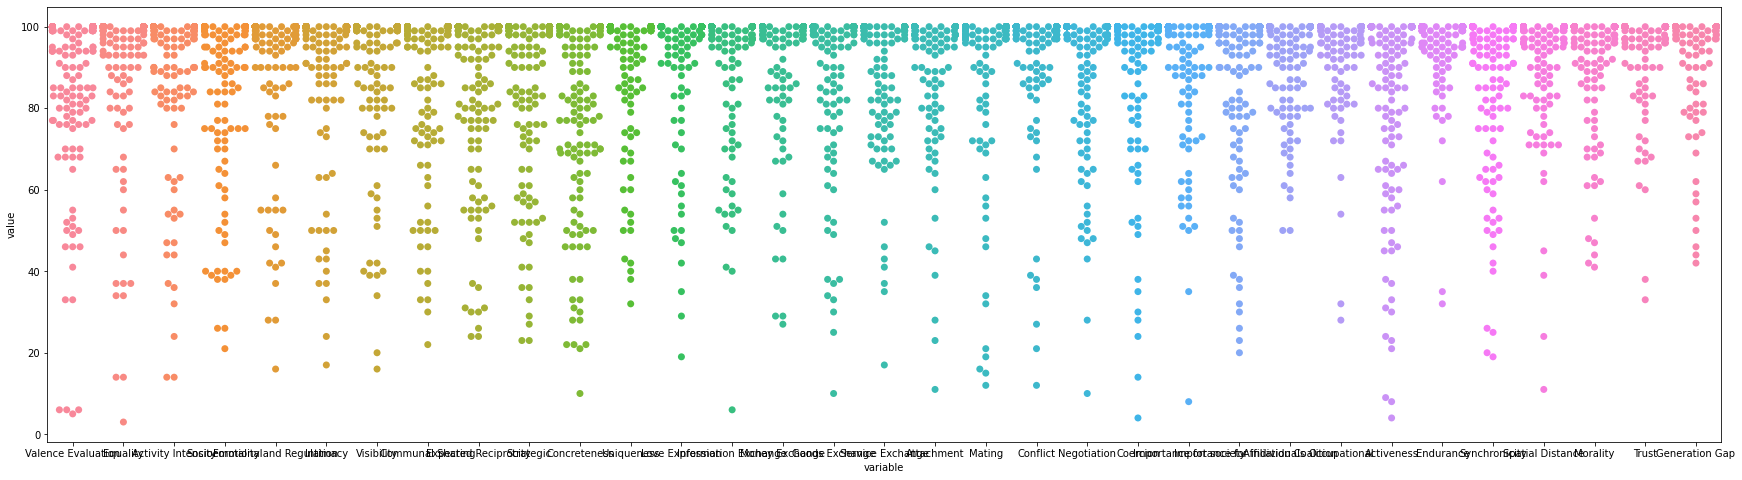

In [7]:
# comprehension of dimensions
response_dim_com = clean_dict_all['dim_com']
dim_com_df_v1 = pd.DataFrame(columns=dimension_33d[0:11])
dim_com_df_v2 = pd.DataFrame(columns=dimension_33d[11:22])
dim_com_df_v3 = pd.DataFrame(columns=dimension_33d[22:33])

# due to the different sample in different version, separate conditon to extract items
count = 4
for dim in dimension_33d:
    filiter_dim = [col for col in response_dim_com.columns if (col.startswith('Q'+str(count)))]
    if count == 33 or count == 36:
        count += 2
    else:
        count +=1
    temp_df = response_dim_com[filiter_dim]
    temp_df = temp_df.dropna(how='all')
    
    dim_list_v1 = []
    dim_list_v2 = []
    dim_list_v3 = []
    if count <= 15:
        for i in range(len(temp_df.index)):
            value = temp_df.iloc[i,:].dropna().values[0]
            dim_list_v1.append(value)
        dim_com_df_v1[dim] = dim_list_v1
        
    if (count > 15) & (count <= 26):
        for i in range(len(temp_df.index)):
            value = temp_df.iloc[i,:].dropna().values[0]
            dim_list_v2.append(value)
        dim_com_df_v2[dim] = dim_list_v2
        
    if count > 26:
        for i in range(len(temp_df.index)):
            value = temp_df.iloc[i,:].dropna().values[0]
            dim_list_v3.append(value)
        dim_com_df_v3[dim] = dim_list_v3

# transform wide into long format
dim_com_df_v1_melt = pd.melt(dim_com_df_v1)
dim_com_df_v2_melt = pd.melt(dim_com_df_v2)
dim_com_df_v3_melt = pd.melt(dim_com_df_v3)
dim_com_df_melt = pd.concat([dim_com_df_v1_melt,dim_com_df_v2_melt,dim_com_df_v3_melt],axis=0)

plt.figure(figsize=(30,8))
sns.swarmplot(data=dim_com_df_melt,x='variable',y='value',size=7)

# Filter and form dictionary

Total number of relationships - 159
Total number of dimensions - 33
Total number of responses, including all participants - 665
Smallest number of ratings for a relationship - 5
Largest number of ratings for a relationship - 18


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total number of responses, excluding bad participants - 614
Smallest number of ratings for a relationship - 5
Largest number of ratings for a relationship - 18


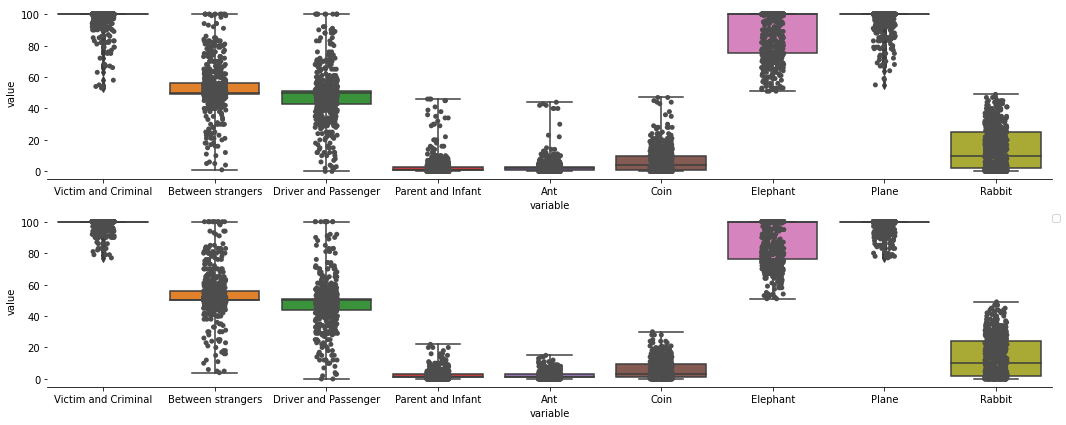

In [8]:
response = clean_dict_all['main']
foils_rel_size = clean_dict_all['rel_size']
familiarity = clean_dict_all['familiarity']

result_dict = dict_data(region = 'Israel',vnum='all',response=response,
                        foils_rel_size=foils_rel_size,familiarity=familiarity,
                        detail_pre=True,detail_after=True)

In [9]:
with pd.ExcelWriter('../dict_results/Israel.xlsx') as writer:
    for dim in result_dict.keys():
        result_dict[dim].to_excel(writer,sheet_name = dim)

# Demographic

In [9]:
outlier_df = pd.read_csv('../output_data/outlier_df/Israel.csv',index_col=0)
outlier_df_list = outlier_df.iloc[:,0].to_list()
foils_rel_size = foils_rel_size.reset_index(drop=True)
foils_rel_size_outliers = foils_rel_size[~foils_rel_size.index.isin(outlier_df_list)]
foils_rel_size_outliers.to_csv('../output_data/foils_rel_size/Israel.csv')
familiarity = familiarity.reset_index(drop=True)
familiarity_outliers = familiarity[~familiarity.index.isin(outlier_df_list)]
familiarity_outliers.to_csv('../output_data/familiarity/Israel.csv')

response_demographic = clean_dict_all['demographic']
response_demographic = response_demographic.reset_index(drop=True)
response_demographic = response_demographic[~response_demographic.index.isin(outlier_df_list)]
response_demographic = response_demographic.iloc[:,2:]

response_demographic.columns = ['Age','Gender','Race','Race_alternative',
                                'Highest education','First language']

In [10]:
dim_com_df = pd.concat([dim_com_df_v1,dim_com_df_v2,dim_com_df_v3])
dim_com_df = dim_com_df.reset_index(drop=True)
dim_com_df_outliers = dim_com_df[~dim_com_df.index.isin(outlier_df_list)]
dim_com_df_outliers.to_csv('../output_data/dimension_comprehension/Israel.csv')

## Gender

In [10]:
# replace index to corresponding label
gender_map = {1:'female',2:'male'}
response_demographic['Gender_label'] = response_demographic['Gender'].map(gender_map)
response_demographic['Gender_label'].value_counts()

female    332
male      282
Name: Gender_label, dtype: int64

## Age

In [11]:
age = response_demographic['Age']
age = age.apply(int)

age_df = pd.DataFrame(columns = ['age','count'])
age_df['age'] = range(1,121)
count_df = []
for i in range(1,121):
    count = 0
    for j in age:
        if i == j:
            count = count + 1
    count_df.append(count)
age_df['count'] = count_df
age_df.to_csv('../output_data/demographic/Israel/age_df.csv')

## Race

In [11]:
race_map = {1:'White',2:'Black',3:'South Asian Indian, Pakistani, etc.',
            4:'East Asian Chinese, Japanese, etc.',5:'Arabic, Central Asian',
            6:'Other (write in)'}
response_demographic['Race_label'] = response_demographic['Race'].map(race_map)
response_demographic['Race_label'].value_counts()

White                                 584
East Asian Chinese, Japanese, etc.     18
Black                                  12
Name: Race_label, dtype: int64

## Highest education

In [12]:
edu_map = {1:'Early childhood education/no education',2:'Primary education',
           3:'Lower secondary education',4:'Upper secondary education',
           5:'Post-secondary non-tertiary education',6:'Short-cycle tertiary education',
           7:'Bachelor or equivalent',8:'Master or equivalent',
           9:'Doctoral or equivalent',10:'Don\'t know/No answer'}
response_demographic['Highest education_label'] = response_demographic['Highest education'].map(edu_map)
response_demographic['Highest education_label'].value_counts()

Post-secondary non-tertiary education    296
Upper secondary education                189
Short-cycle tertiary education           107
Bachelor or equivalent                    21
Lower secondary education                  1
Name: Highest education_label, dtype: int64

In [13]:
response_demographic.to_csv('../output_data/demographic/Israel.csv')

## First language

In [14]:
response_demographic['First language'].value_counts()

עברית                              360
Hebrew                              50
hebrew                              38
רוסית                               35
עברית                               19
English                             16
אנגלית                              14
Hebrew                              13
ערבית                               10
russian                              9
HEBREW                               8
Russian                              5
עברית, אנגלית                        5
אנגלית+עברית                         4
הונגרית                              3
hebrew(עברית)                        3
english and hebrew                   2
עברית HEBREW                         2
English, hebrew                      2
עברית ורוסית russian and hebrew      2
Arabic                               2
עברית ואנגלית                        2
עברית ורוסית                         2
english, hebrew                      1
אנגלית                               1
עברית(hebrew)            

# Heatmap

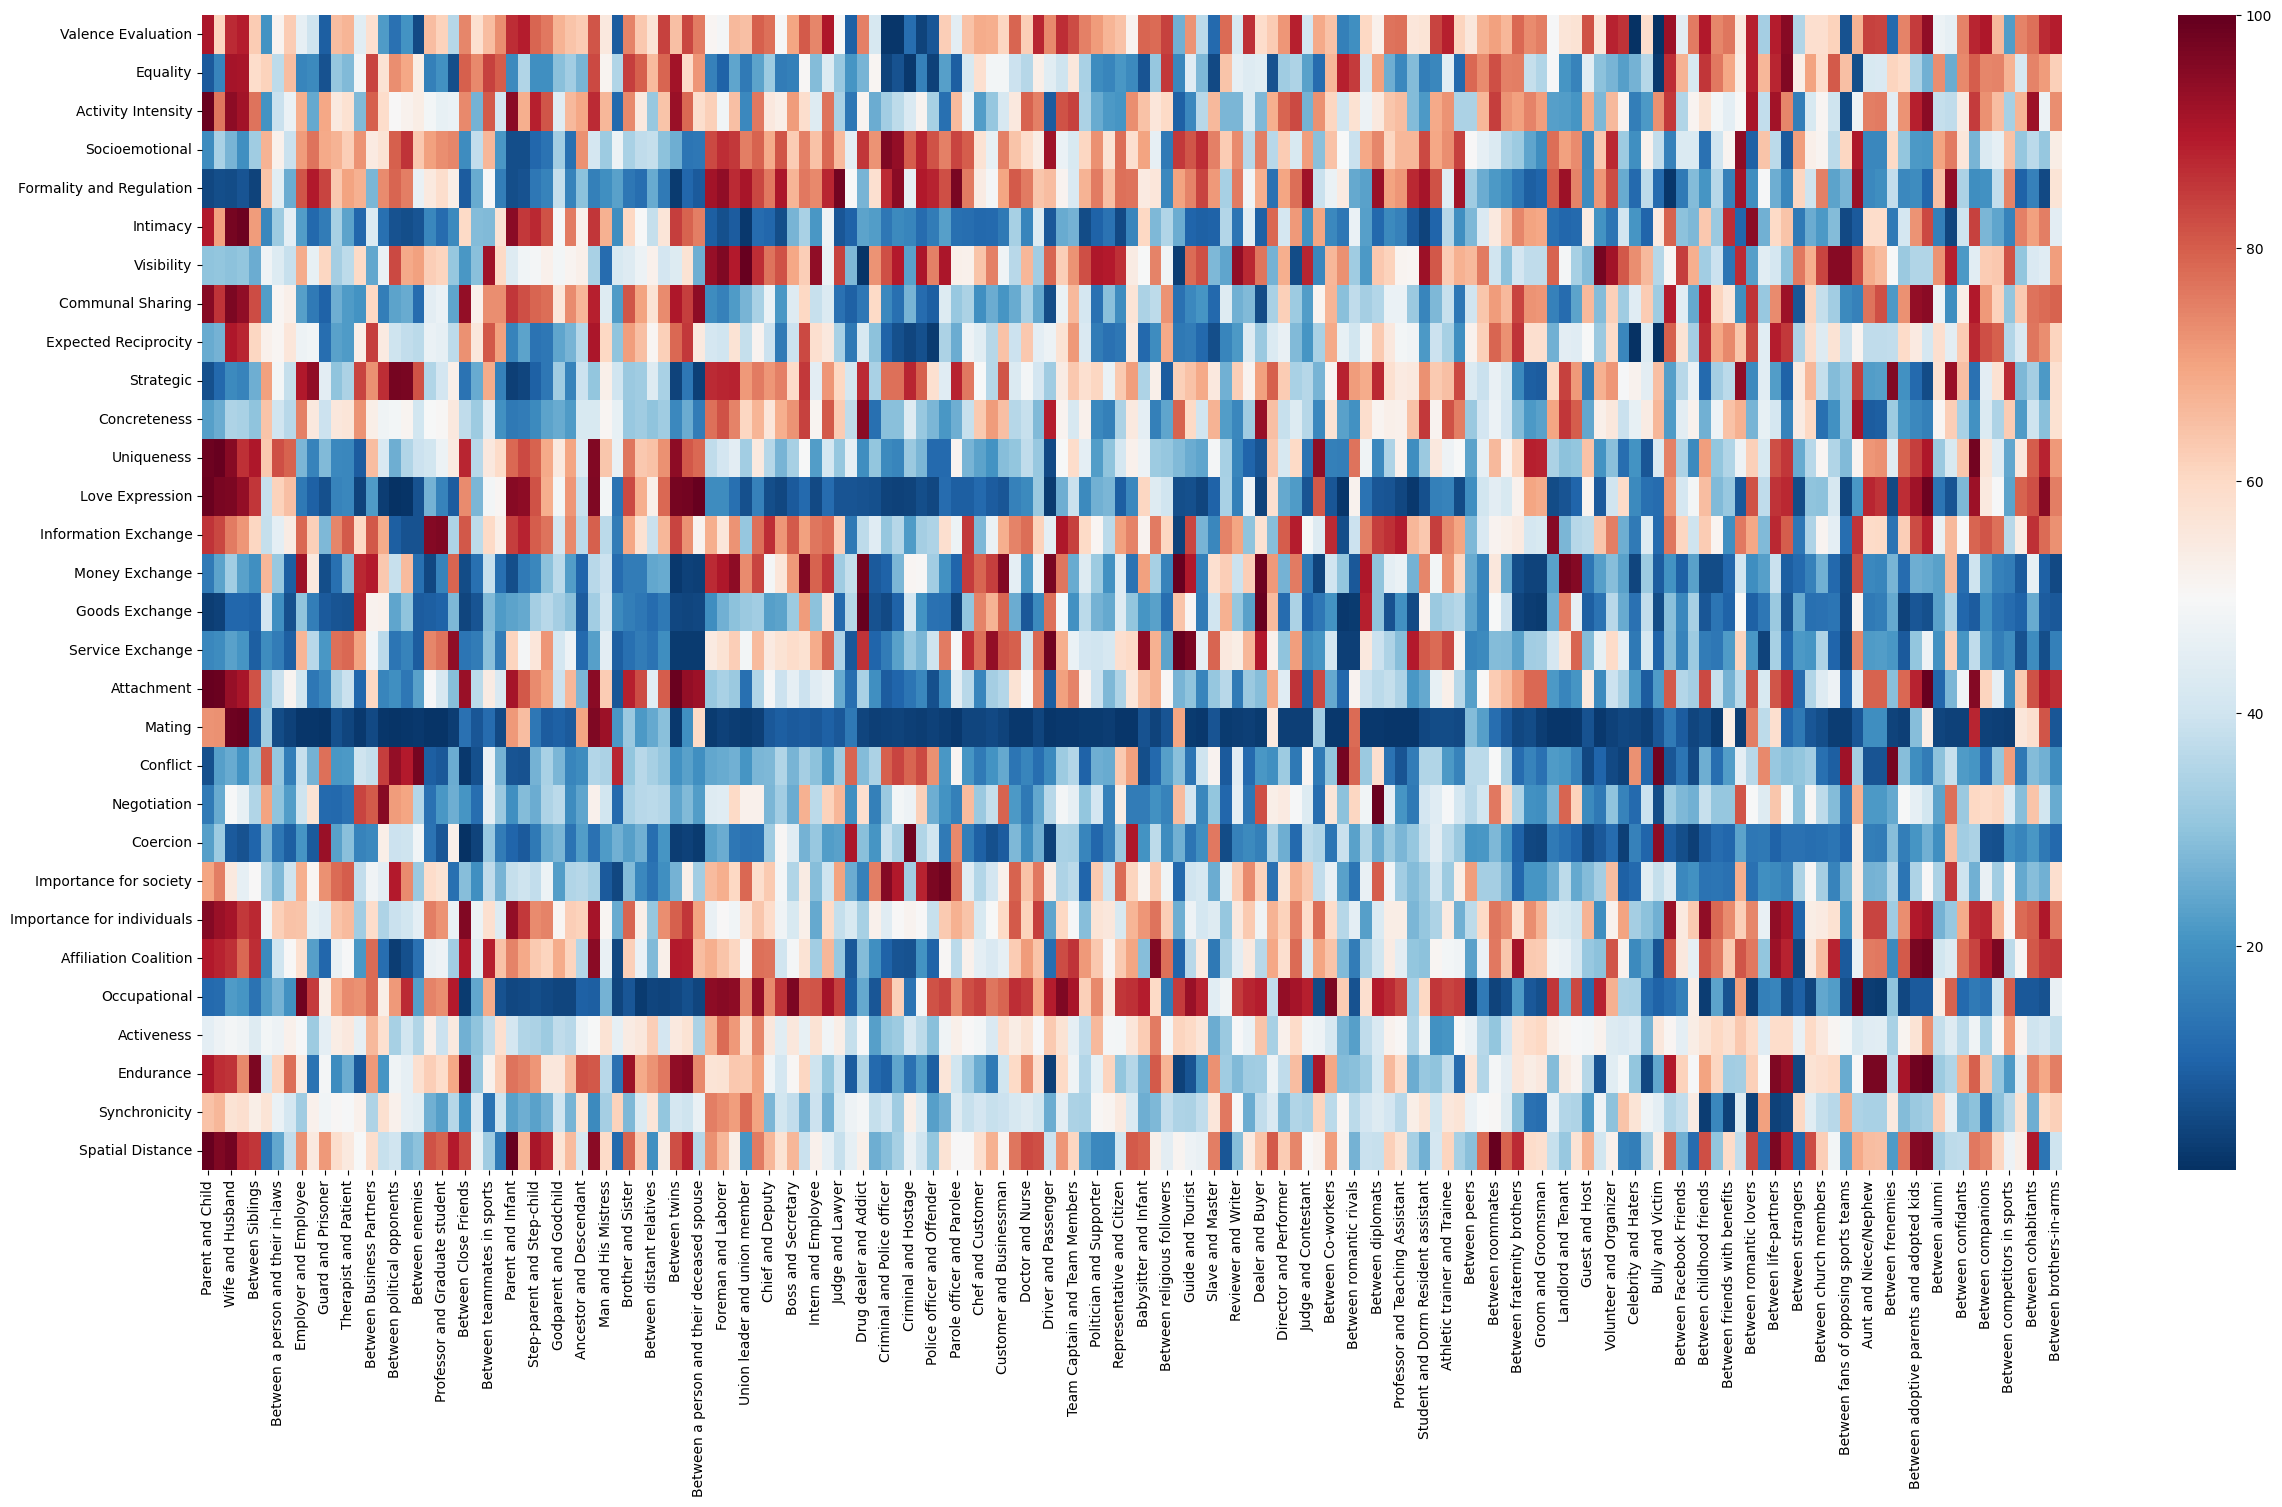

In [15]:
dim_rel = pd.DataFrame(columns=relationships)
count=0
col_names = []
for dim in result_dict.keys():
    dim_rel.loc[count] = result_dict[dim].mean().tolist()
    col_names.append(dim)
    count = count + 1
dim_rel.index = result_dict.keys()
dim_rel.to_csv('../output_data/cleaning_results/Israel/Israel_dim_rel.csv')
dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled_df = pd.DataFrame(dim_rel_scaled, index=dim_rel.columns,
                                 columns=dim_rel.index)
dim_rel_scaled_df.to_csv('../output_data/cleaning_results/Israel/Israel_dim_rel_scaled.csv')

## Filter 159*30
dim_rel_30d = dim_rel.iloc[:30]
plt.figure(figsize=(30,15))
heatmap = sns.heatmap(dim_rel_30d, center=50,cmap="RdBu_r")
fig = heatmap.get_figure()
dim_rel_30d.to_csv('../output_data/cleaning_results/Israel/Israel_dim_rel_30d.csv')
dim_rel_scaled_30d_df = dim_rel_scaled_df.iloc[:,:30]
dim_rel_scaled_30d_df.to_csv('../output_data/cleaning_results/Israel/Israel_dim_rel_scaled_30d.csv')

# PCA with varimax rotation

In [2]:
library(tidyverse)
library(reshape)

library(psych)
#optimal number of components
library(nFactors)

library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(corrplot)

In [3]:
plotnScree <-
function (nScree,
          elbow = 3,
          legend = TRUE,
          ylab   = "Eigenvalues",
          xlab   = "Components",
          main   = "Non Graphical Solutions to Scree Test")
          {
   if (!inherits(nScree, "nScree"))  stop("Method is only for nScree objects")
   #if (!exists("legend", mode="logical") ) legend <- TRUE                                   # To develop
   #if (!exists("ylab"))                    ylab <- "Eigenvalues"                            # To develop
   #if (!exists("xlab"))                    xlab <- "Components"                             # To develop
   #if (!exists("main"))                    main <- "Non Graphical Solutions to Scree Test"  # To develop
   if (nScree$Model == "components") nkaiser = "Eigenvalues (>mean  = " else nkaiser = "Eigenvalues (>0 = "
   if (nScree$Model == "factors")  xlab   = "Factors"
   par(col   = 1, pch = 1)     # Color and symbol for usual scree
   par(mfrow = c(1,1),lwd=2)
   eig        <- nScree$Analysis$Eigenvalues
   k          <- 1:length(eig)
   #plotuScree(x=eig, ...)                                                                   # To develop
   plotuScree(x=eig, main=main, xlab=xlab, ylab=ylab)
   nk         <- length(eig)
   noc        <- nScree$Components$noc
   vp.p       <- lm(eig[c(noc+1,nk)] ~ k[c(noc+1,nk)])
   x          <- sum(c(1,1) * coef(vp.p))
   y          <- sum(c(1,nk)* coef(vp.p))
   par(col = 10)            # Color for optimal coordinates
   lines(k[c(1,nk)],c(x,y),lwd=1.8)
   par(col = 11,pch=2)            # Color and symbol for parallel analysis
   lines(1:nk, nScree$Analysis$Par.Analysis, type = "b",lwd=1.8)
   if (legend == TRUE) {
     leg.txt  <- c(paste("Parallel Analysis (n = ",nScree$Components$nparallel,")"),
                 c(paste("Kaiser-Guttman rule (n = ",nScree$Components$nkaiser,")")),
                 c(paste("Cattell’s scree test (n = ",elbow,")")),
                 c(paste("Optimal Coordinates (n = ",nScree$Components$noc,")")) )
     legend("topright",
            legend   = leg.txt,
            pch      = c('△','_','○','_'),
            text.col = c(3,4,1,2), 
            col = c(3,4,1,2),
            cex = 1.3)
     }
   naf        <-   nScree$Components$naf
   text(x = noc ,    y = eig[noc],     label = " (OC)", cex = 1, adj = c(0,0), col = 2)
#    text(x = naf + 1, y = eig[naf + 1], label = " (AF)", cex = .70, adj = c(0,0), col = 4)
   }

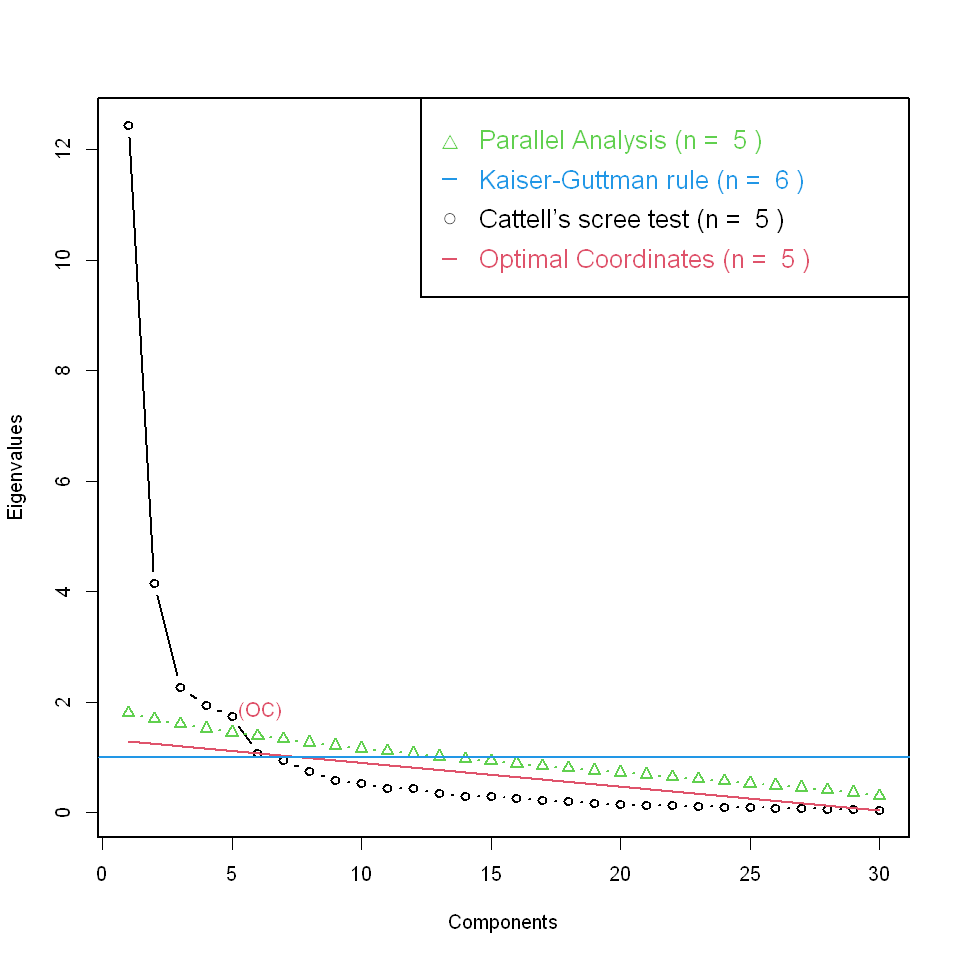

In [4]:
# import relationship dimension ratings scaled from the Data cleaning's output
dim_rel_scaled = read.csv('../output_data/cleaning_results/Israel/Israel_dim_rel_scaled_30d.csv', 
                          row.names=1,encoding='UTF-8',check.names=FALSE)

options(repr.plot.width=8, repr.plot.height=8)
# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(dim_rel_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(dim_rel_scaled),var=ncol(dim_rel_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05

plotnScree(nS,elbow = 5, legend=TRUE, main = NULL)
abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule

## 5d solution

In [6]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

write.csv(loadings_var,'../output_data/pca_results/Israel/Israel_loadings_var_5c_30d.csv')
scores_var = as.data.frame(scores_var)
write.csv(scores_var,'../output_data/pca_results/Israel/Israel_scores_var_5c_30d.csv')

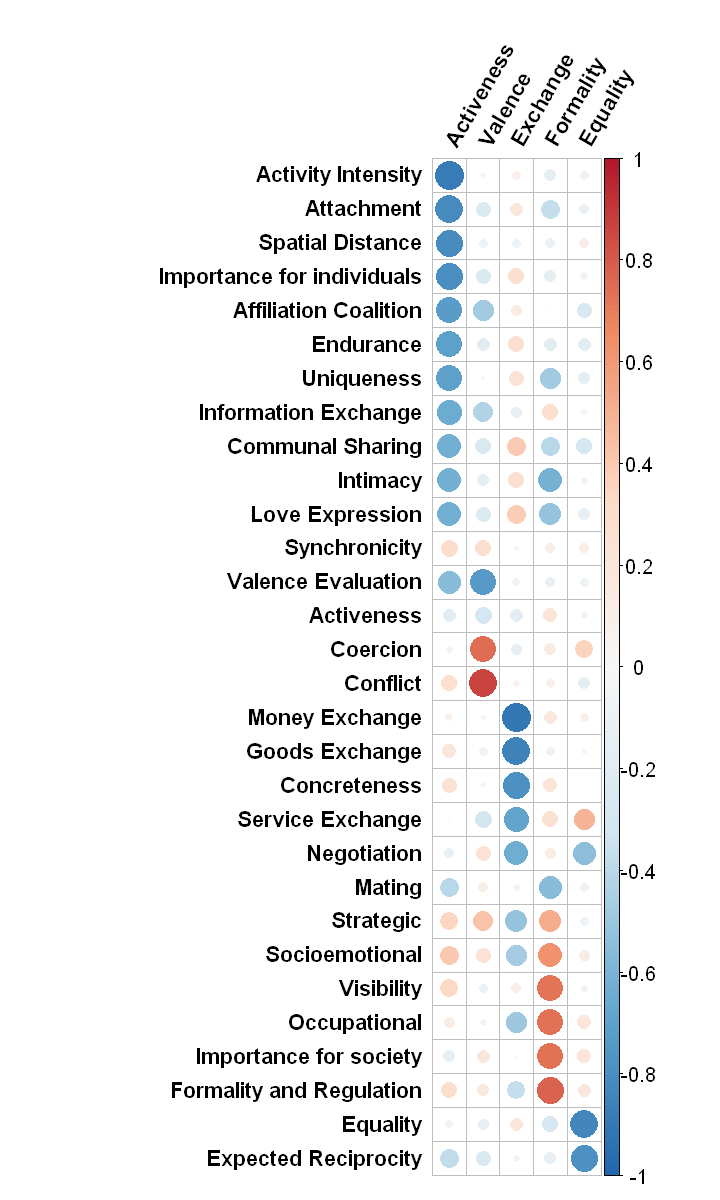

In [8]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:30)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(V5)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

colnames(loadings_var_reorder) = c('Activeness','Valence','Exchange','Formality','Equality')
options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

## 33d

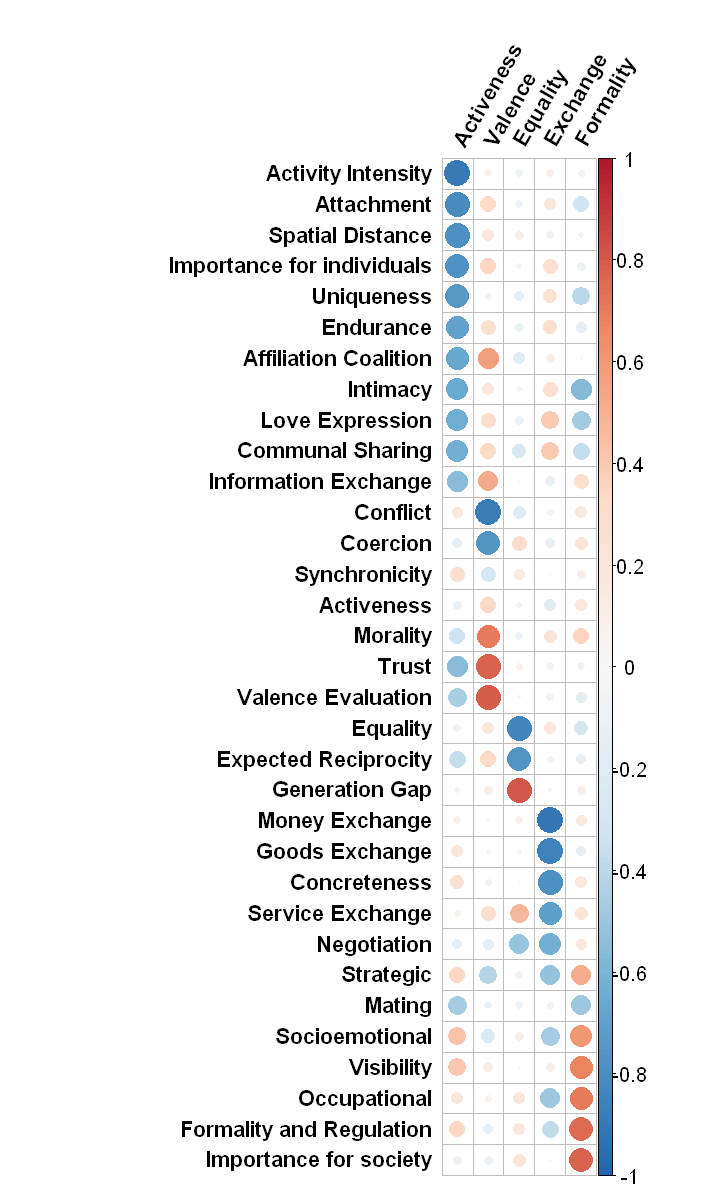

In [5]:
dim_rel_scaled_33d = read.csv('../output_data/cleaning_results/Israel/Israel_dim_rel_scaled.csv',
                          row.names=1,encoding='UTF-8',check.names=FALSE)

dim_rel.pca = prcomp(dim_rel_scaled_33d)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

write.csv(loadings_var,'../output_data/pca_results/Israel/Israel_loadings_var_5c_33d.csv')
scores_var = as.data.frame(scores_var)
write.csv(scores_var,'../output_data/pca_results/Israel/Israel_scores_var_5c_33d.csv')

#####################################################################################
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(V5)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

colnames(loadings_var_reorder) = c('Activeness','Valence','Equality','Exchange','Formality')
options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))